In [2]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

C:\Users\emjan\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data = pd.read_csv('data/AirfoilSelfNoise.csv')

# A brief information about the data set:
# Input features:
# F: Frequency in Hertzs [Hz].
# alpha: Angle of attack (AoA, α), in degrees [°].
# C: Chord length, in meters [m].
# U_infinity: Free-stream velocity, in meters per second [m/s].
# delta: Suction side displacement thickness (𝛿), in meters [m].

# Output: SSPL: Scaled sound pressure level, in decibels [dB]. 

# 1.) Data Processing and Visualization


In [4]:
data = data.rename(columns={"f": "Frequency", "alpha": "Angle of Attack", "c": "Chord Length", "U_infinity": 
"Free-stream velocity", "delta": "Section side displacement thickness" , "SSPL": "Scaled Sound Pressure Level"})

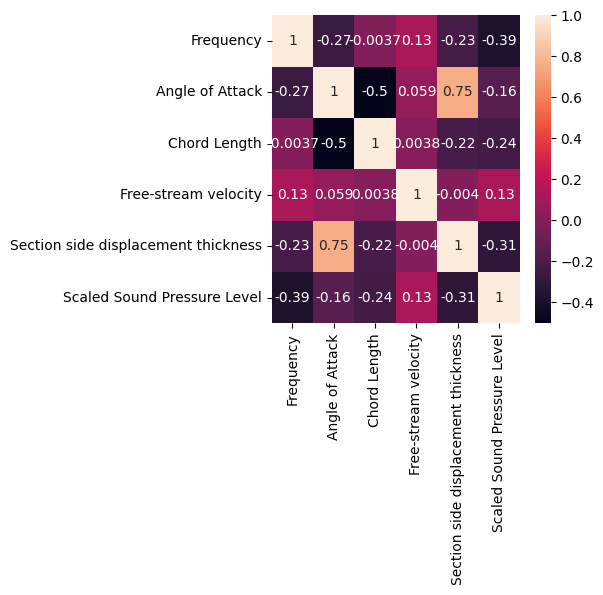

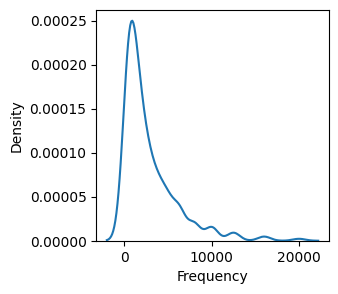

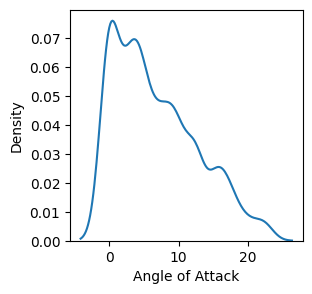

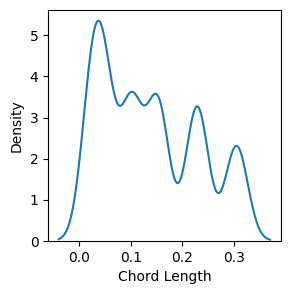

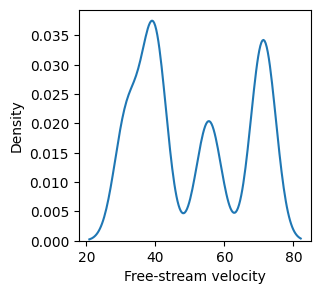

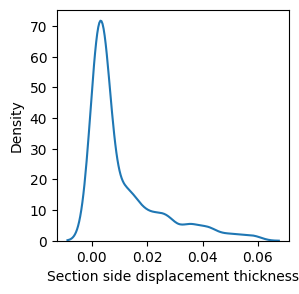

<Figure size 300x300 with 0 Axes>

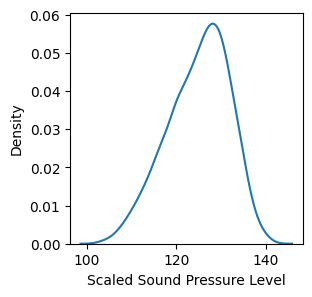

In [19]:
plt.figure(figsize=(4, 4))
sns.heatmap(data.corr(),annot=True)

# Univariate Analysis
plt.figure(figsize=(3, 3))
sns.kdeplot(data['Frequency'])
plt.show()
plt.figure(figsize=(3, 3))
sns.kdeplot(data['Angle of Attack'])
plt.show()
plt.figure(figsize=(3, 3))
sns.kdeplot(data['Chord Length'])
plt.show()
plt.figure(figsize=(3, 3))
sns.kdeplot(data['Free-stream velocity'])
plt.show()
plt.figure(figsize=(3, 3))
sns.kdeplot(data['Section side displacement thickness'])
plt.figure(figsize=(3, 3))
plt.show()
plt.figure(figsize=(3, 3))
sns.kdeplot(data['Scaled Sound Pressure Level'])
plt.show()

# Density is just the density of the data, not the physical property

# 2.) Data Processing for the Model

In [6]:
x_processed = np.array(data[["Frequency","Chord Length","Free-stream velocity","Angle of Attack","Section side displacement thickness"]])
y_processed = np.array(data[["Scaled Sound Pressure Level"]])
x_train, x_test, y_train, y_test = train_test_split(x_processed, y_processed,train_size=0.85)
scaler = StandardScaler()

# Transform original data
x_train = scaler.fit_transform(x_train)
x_test  = scaler.fit_transform(x_test)

# Converion to tensor
x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

print(x_train.dtype)

torch.float64


# 3.) Forming the Neural Network Model

In [7]:
# LF NN Hyper Paramters
input_dim = 5
output_dim = 1
LF_num_epochs = 1000
LF_hidden_dims = (5*[100, 200, 300, 400, 512])

# Low Fidelity Neural Network
class NeuralNetwork(torch.nn.Module):
  def __init__(self, input_dim, LF_hidden_dims, output_dim):
    super().__init__()
    self.fc1 = torch.nn.Linear(input_dim, LF_hidden_dims[0])
    self.fc2 = torch.nn.Linear(LF_hidden_dims[0], LF_hidden_dims[1])
    self.fc3 = torch.nn.Linear(LF_hidden_dims[1], LF_hidden_dims[2])
    self.fc4 = torch.nn.Linear(LF_hidden_dims[2], LF_hidden_dims[3])
    self.fc5 = torch.nn.Linear(LF_hidden_dims[3], output_dim)
    # self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.relu(self.fc3(x))
    x = torch.relu(self.fc4(x))
    # x = self.dropout(x)
    x = self.fc5(x)
    return x

LF_model = NeuralNetwork(input_dim, LF_hidden_dims, output_dim).to(device)

for param in LF_model.parameters():
    param.data = param.data.to(torch.float64)

In [8]:
criterion = torch.nn.MSELoss().to(device)
LF_optimizer = torch.optim.Adam(LF_model.parameters())

LF_losses = []
for epoch in range(LF_num_epochs):
  LF_y_pred = LF_model(x_train.to(device))
  LF_loss = criterion(LF_y_pred, y_train.to(device))
  LF_losses.append(LF_loss.item())
  LF_optimizer.zero_grad()
  LF_loss.backward()
  LF_optimizer.step()

final_loss = LF_losses[-1]
print(f"Final Loss: {final_loss}")

Final Loss: 7.8919174822919285


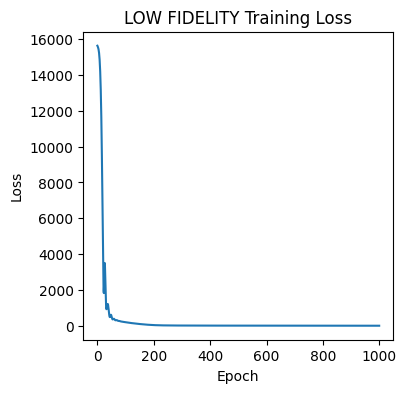

In [9]:
plt.figure(figsize = (4, 4))
plt.plot(LF_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LOW FIDELITY Training Loss')
plt.show()

Mean Squared Error: 9.992617751374686
torch.Size([226, 1])
torch.Size([226, 5])


Text(0, 0.5, 'Scaled Sound Pressure Level (dB)')

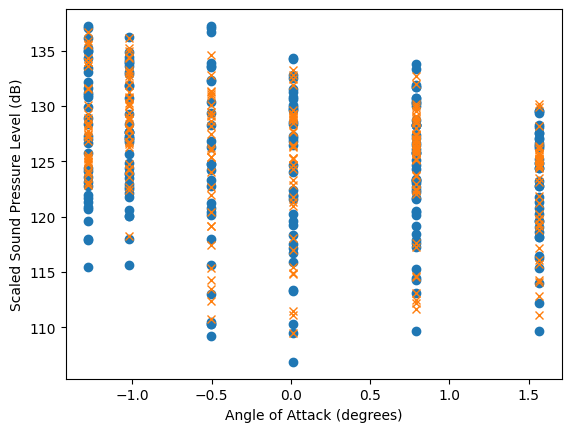

In [10]:
# Set the model to evaluation mode
LF_model.eval()

# Compute predictions on the test set
with torch.no_grad():
    y_pred = LF_model(x_test.to(device))

mse = ((y_pred.cpu() - y_test) ** 2).mean()
print(f"Mean Squared Error: {mse}")
print(y_test.shape)
print(x_test.shape)

plt.plot(x_test[:,1], y_test, "o")
plt.plot(x_test[:,1], y_pred.cpu(), "x")
plt.xlabel("Angle of Attack (degrees)")
plt.ylabel("Scaled Sound Pressure Level (dB)")